In [1]:
import os
import cv2
import json
import torch
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from glob import glob
import os.path as osp
import torch.nn.functional as F
from sklearn.cluster import KMeans
from torchvision import transforms
from transformers import CLIPModel
from torchvision import transforms
from argparse import ArgumentParser
from utils_dir.backbones_utils import load_backbone, extract_backbone_features, get_backbone_params, load_backbone_and_tokenizer, prepare_image_for_backbone
from utils_dir.coco_to_seg import coco_to_seg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A

# Normalization from CoOp
from torchvision.transforms import Normalize
PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]

from build_prototypes import build_object_prototypes
from argparse import ArgumentParser

/home/gridsan/manderson/.conda/envs/ovdsat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gridsan/manderson/.local/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Check CoOp prototypes

In [10]:
text_features_coop = torch.load("CoOp/text_features_coop_test.pt", map_location=torch.device("cpu"))
text_features_coop_remake = torch.load('run/coop_prototypes/boxes/dior_N30-1/prototypes_remoteclip-14-coop.pt', map_location=torch.device("cpu"))['prototypes']
prompts_coop = torch.load('CoOp/prompts_coop_test.pt', map_location=torch.device('cpu'))
tokenized_prompts_coop = torch.load('CoOp/tokenized_prompts_coop_test.pt', map_location=torch.device('cpu'))
print(text_features_coop.shape)
print(prompts_coop.shape)
print(tokenized_prompts_coop.shape)

torch.Size([20, 768])
torch.Size([20, 77, 768])
torch.Size([20, 77])


In [11]:
print(text_features_coop.dtype)

torch.float16


In [12]:
text_features_ovdsat = torch.load('run/coop_prototypes/boxes/dior_N30-1/prototypes_remoteclip-14.pt', map_location=torch.device("cpu"))['prototypes']
prompts_ovdsat = torch.load('run/coop_prototypes/boxes/dior_N30-1/prompts_remoteclip-14.pt', map_location=torch.device("cpu"))
tokenized_prompts_ovdsat = torch.load('run/coop_prototypes/boxes/dior_N30-1/tokenized_prompts_remoteclip-14.pt', map_location=torch.device("cpu"))
print(text_features_ovdsat.shape)
print(prompts_ovdsat.shape)
print(tokenized_prompts_ovdsat.shape)

torch.Size([20, 768])
torch.Size([20, 77, 768])
torch.Size([20, 77])


In [13]:
print(text_features_ovdsat.dtype)

torch.float16


In [14]:
print(torch.equal(prompts_coop, prompts_ovdsat))
print(prompts_coop[5,0,:10])
print(prompts_ovdsat[5,0,:10])

True
tensor([ 0.0015,  0.0031,  0.0006, -0.0019, -0.0013,  0.0024,  0.0014, -0.0023,
         0.0014, -0.0010], dtype=torch.float16)
tensor([ 0.0015,  0.0031,  0.0006, -0.0019, -0.0013,  0.0024,  0.0014, -0.0023,
         0.0014, -0.0010], dtype=torch.float16)


In [15]:
print(torch.equal(text_features_coop, text_features_ovdsat))
text_features_ovdsat_float = text_features_ovdsat.to(torch.float16)
print(text_features_coop[5:10,:5])
print(text_features_ovdsat_float[5:10,:5])

True
tensor([[-0.3105, -0.1450,  0.9067,  0.0571, -0.6255],
        [-0.4998,  0.4690,  0.4795, -0.5132, -0.4146],
        [-0.5498, -0.0465,  0.5103, -0.0719, -0.4678],
        [-0.4849,  0.1758,  0.1852, -0.7461, -0.5220],
        [ 0.2135, -0.3252,  0.6143,  0.0969, -0.7300]], dtype=torch.float16)
tensor([[-0.3105, -0.1450,  0.9067,  0.0571, -0.6255],
        [-0.4998,  0.4690,  0.4795, -0.5132, -0.4146],
        [-0.5498, -0.0465,  0.5103, -0.0719, -0.4678],
        [-0.4849,  0.1758,  0.1852, -0.7461, -0.5220],
        [ 0.2135, -0.3252,  0.6143,  0.0969, -0.7300]], dtype=torch.float16)


In [16]:
print(torch.equal(tokenized_prompts_coop, tokenized_prompts_ovdsat))
print(tokenized_prompts_coop[0,:10])
print(tokenized_prompts_ovdsat[0,:10])

True
tensor([49406,   320, 10316,  2867,   539, 31658,  2086,  2445,   269, 49407])
tensor([49406,   320, 10316,  2867,   539, 31658,  2086,  2445,   269, 49407])


In [ ]:
# # Save CoOp prototype version
# prototypes_remake = torch.load('run/coop_prototypes/boxes/dior_N30-1/prototypes_remoteclip-14-ovdsat.pt', map_location=torch.device("cpu"))
# print(prototypes_remake['prototypes'][5:10,:5])
# prototypes_remake['prototypes'] = text_features_coop
# print(prototypes_remake['prototypes'][5:10,:5])
# torch.save(prototypes_remake, '/home/gridsan/manderson/ovdsat/run/coop_prototypes/boxes/dior_N30-1/prototypes_remoteclip-14.pt')

### Testing

In [ ]:
import json
train_coco = '/home/gridsan/manderson/ovdsat/data/dior/train_coco_subset_N5-1.json'

In [ ]:
# Load the JSON file
with open(train_coco, "r") as f:
    data = json.load(f)

# Check if 'images' exists
if "images" in data:
    print("Found 'images' section")

    # Check for a specific item, e.g., file_name = "dog.jpg"
    exists = any(img.get("file_name") == "21589.jpg" for img in data["images"])

    if exists:
        print("Item exists in images ✅")
    else:
        print("Item not found ❌")
else:
    print("'images' key not found in JSON")

In [ ]:
parser = ArgumentParser()
parser.add_argument('--data_dir', type=str, default='data/simd_subset_10')
parser.add_argument('--save_dir', type=str, default='/mnt/ddisk/boux/code/ovdsat/run/classification_benchmark_exp')
parser.add_argument('--annotations_file', type=str, default='/mnt/ddisk/boux/code/data/simd/train_coco_subset_N10.json')
parser.add_argument('--backbone_type', type=str, default='dinov2')
parser.add_argument('--target_size', nargs=2, type=int, metavar=('width', 'height'), default=(602, 602))
parser.add_argument('--window_size', type=int, default=224)
parser.add_argument('--scale_factor', type=int, default=1)
parser.add_argument('--num_b', type=int, default=10, help='Number of background samples to extract per image')
parser.add_argument('--k', type=int, default=200, help='Number of background prototypes (clusters for k-means)')
parser.add_argument('--store_bg_prototypes', action='store_true', default=False)

In [ ]:
DATA_DIR = 'data'
backbone = 'dinov2'
dataset = 'dior'
N=5
M=6

In [ ]:
args = parser.parse_args([
    '--data_dir', f'{DATA_DIR}/{dataset}/JPEGImages',
    '--save_dir', f'run/init_prototypes/boxes/{dataset}_N{N}-{M}',
    '--annotations_file', f'{DATA_DIR}/{dataset}/train_coco_subset_N{N}-{M}.json',
    '--backbone_type', backbone,
    '--target_size', '602', '602',
    '--window_size', '224',
    '--scale_factor', '1',
    '--num_b', '10',
    '--k', '200',
    '--store_bg_prototypes'
])

In [ ]:
# Convert COCO annotations to segmentation masks
init_data_path = os.path.join('data', 'init_data', args.save_dir.split('/')[-1])
coco_to_seg(args.annotations_file, args.data_dir, init_data_path)

### Random

In [ ]:
init_data_path = 'data/init_data/test-n'
annotations_file = '/home/gridsan/manderson/ovdsat/data/test-n.json'

In [ ]:
coco_to_seg(annotations_file, f'{DATA_DIR}/{dataset}/JPEGImages', init_data_path)

In [ ]:
# Convert COCO annotations to segmentation masks
init_data_path = os.path.join('data', 'init_data', args.save_dir.split('/')[-1])
coco_to_seg(args.annotations_file, args.data_dir, init_data_path)


# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_backbone(args.backbone_type)
model = model.to(device)
model.eval()
patch_size, _ = get_backbone_params(args.backbone_type)

# Build object prototypes
obj_category_dict = build_object_prototypes(args, model, init_data_path, device, patch_size)

### Text (zero-shot)

In [ ]:
zero_shot_prot = torch.load('/home/gridsan/manderson/ovdsat/run/text_prototypes/boxes/dior/prototypes_remoteclip-14.pt')

In [ ]:
print(zero_shot_prot['prototypes'].shape)

### CoOp

In [ ]:
model, tokenizer = load_backbone_and_tokenizer('remoteclip-14')

In [ ]:
context_path = '/home/gridsan/manderson/ovdsat/CoOp/output/dior/CoOp/vit_l14_remote-ep100-ctx2-crop-nobg_30shots/nctx4_cscFalse_ctpmiddle/seed1/prompt_learner/model.pth.tar-100'
context = torch.load(context_path, map_location=torch.device('cpu'))

In [ ]:
print(context.keys())

In [ ]:
print(context['state_dict'].keys())

In [ ]:
prefix = context['state_dict']['token_prefix']
ctx = context['state_dict']['ctx']
suffix = context['state_dict']['token_suffix']

In [ ]:
print(prefix.shape)
print(ctx.shape)
print(suffix.shape)

In [ ]:
print(prefix[:,:,:3])

In [ ]:
print(suffix[:,0,:5])

In [ ]:
# # for end, class specific
# prompts = torch.cat(
#     [
#         prefix,  # (n_cls, 1, dim)
#         ctx,     # (n_cls, n_ctx, dim)
#         suffix,  # (n_cls, *, dim)
#     ],
#     dim=1,
# )
# prompts.shape

In [ ]:
classes = ['expressway service area', 'expressway toll station', 'airplane', 'airport', 'baseball field', 'basketball court', 'bridge', 'chimney', 'dam', 'golf field', 'ground track field', 'harbor', 'overpass', 'ship', 'stadium', 'storage tank', 'tennis court', 'train station', 'vehicle', 'windmill']
for name in classes:
    tokens = len(tokenizer.encode(name))
    #print(tokens)
    # token_embed = model.token_embedding(tokens)
    # print(token_embed[:10])

In [ ]:
from CoOp.clip import clip

def load_clip_to_cpu():
    
    backbone_name = 'ViT-L/14'
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())
    
    ## TODO dont hardcode
    state_dict = torch.load('/home/gridsan/manderson/ovdsat/weights/RemoteCLIP-ViT-L-14.pt', map_location="cpu")
    model = clip.build_model(state_dict)
    model.float()
        
    return model

n_ctx = 4

clip_model = load_clip_to_cpu()

prompt_prefix = "a satellite image of"
prompts = [prompt_prefix + " " + class_name + "." for class_name in classes]
tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])
with torch.no_grad():
    embedding = clip_model.token_embedding(tokenized_prompts).type(clip_model.dtype)
suffix = embedding[:, 1 + n_ctx :, :]   

In [ ]:
print(suffix.shape)
print(suffix[:,1,:5])

In [ ]:
#classnames = [name.replace("_", " ") for name in classes]
class_names = classes
print('CLASSNAMES', classnames)
#name_lens = [len(_tokenizer.encode(name)) for name in classes]
name_lens = [len(tokenizer.encode(name)) for name in classes]
print('name_lens')
print(name_lens)
prompts = [prompt_prefix + " " + name + "." for name in classnames]

tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])
#tokenized_prompts = torch.cat([_tokenizer(p) for p in prompts]) # CHANGE: tokenizer
with torch.no_grad():
    embedding = clip_model.token_embedding(tokenized_prompts)
    
coop_suffix = embedding[:, 1 + n_ctx :, :]

In [ ]:
print(coop_suffix.shape)
print(coop_suffix[:,1,:5])

In [ ]:
# for middle, unified
classes = ['ground track field', 'baseball field', 'bridge', 'expressway toll station', 'vehicle', 'airplane', 'airport', 'tennis court', 'train station', 'storage tank', 'stadium', 'windmill', 'ship', 'golf field', 'overpass', 'chimney', 'dam', 'basketball court', 'harbor', 'expressway service area']
name_lens = [len(tokenizer.encode(name)) for name in classes]
n_ctx = 4
n_cls = 20

if ctx.dim() == 2:
    ctx = ctx.unsqueeze(0).expand(n_cls, -1, -1)

half_n_ctx = n_ctx // 2
prompts = []
for i in range(n_cls):
    name_len = name_lens[i]
    prefix_i = prefix[i : i + 1, :, :]
    class_i = suffix[i : i + 1, :name_len, :]
    print(class_i.shape)
    suffix_i = suffix[i : i + 1, name_len:, :]
    ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
    ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
    prompt = torch.cat(
        [
            prefix_i,     # (1, 1, dim)
            ctx_i_half1,  # (1, n_ctx//2, dim)
            class_i,      # (1, name_len, dim)
            ctx_i_half2,  # (1, n_ctx//2, dim)
            suffix_i,     # (1, *, dim)
        ],
        dim=1,
    )
    prompts.append(prompt)
prompts = torch.cat(prompts, dim=0)
prompts.shape

In [ ]:
text_encoder = model.transformer
text_feats = text_encoder(prompts.to('cpu'))
text_feats.shape

In [ ]:
text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
text_feats = text_feats[:, 0, :] #CLS token
text_feats.shape # Final shape of text prototypes should be [n_classes, dim=768]

In [ ]:
coop_classes = ['Ground Track Field', 'Baseball Field', 'Bridge', 'Expressway Toll Station', 'Vehicle', 'Airplane', 'Airport', 'Tennis Court', 'Train Station', 'Storage Tank', 'Stadium', 'Windmill', 'Ship', 'Golf Field', 'Overpass', 'Chimney', 'Dam', 'Basketball Court', 'Harbor', 'Expressway Service Area']

In [ ]:
with open('/home/gridsan/manderson/ovdsat/data/text/dior_labels.txt', "r") as f:
        classes = [line.strip() for line in f]

### CoOp Prompt

In [ ]:
# Compare with CoOp weights

context_path = '/home/gridsan/manderson/ovdsat/CoOp/output/dior/CoOp/vit_l14_remote-ep100-ctx2-crop-nobg_30shots/nctx4_cscFalse_ctpmiddle/seed1/prompt_learner/model.pth.tar-100'
context = torch.load(context_path, map_location=torch.device('cpu'))

prefix = context['state_dict']['token_prefix']
ctx = context['state_dict']['ctx']
suffix = context['state_dict']['token_suffix']
print(suffix.shape)

#print(prefix[:,:,:3])
#print(ctx[1,:3])
print(suffix[:,1,:3])

In [ ]:
print(ctx[2,:3])

In [ ]:
prompt_path = 'run/coop_prototypes/boxes/dior_N30-1/prompts_remoteclip-14.pt'
prompt = torch.load(prompt_path)

In [ ]:
print(prompt.shape)
print(prompt[:,4,:3])

In [ ]:
prompt_path = 'run/coop_prototypes/boxes/dior_N30-1/old/prompts_remoteclip-14.pt'
prompt = torch.load(prompt_path)
print(prompt[:,4,:3])

### Understanding CoOp

In [ ]:
import open_clip

In [ ]:
n_ctx = 16

In [ ]:
classnames = ['airplane', 'boat', 'car']
name_lens = [len(open_clip.tokenize(name)) for name in classnames]
name_lens

In [ ]:
prompt_prefix = " ".join(["X"] * n_ctx)
prompt_prefix

In [ ]:
prompts = [prompt_prefix + " " + name + "." for name in classnames]
print(len(prompts[0]))
prompts # Prompts [n_classes, num_words]

In [ ]:
tokenized_prompts = torch.cat([open_clip.tokenize(p) for p in prompts])
tokenized_prompts.shape # Tokenized prompts [n_classes, num_tokens] (num_tokens usually 77 with padding)

In [ ]:
print(tokenized_prompts[0])

In [ ]:
with torch.no_grad():
    embedding = model.token_embedding(tokenized_prompts)
embedding.shape # Token embeddings [n_classes, num_tokens, dim]

### CoOp text and object prototype similarity

In [ ]:
from CoOp.clip import clip

def load_clip_to_cpu():
    
    backbone_name = 'ViT-L/14'
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())
    
    ## TODO dont hardcode
    state_dict = torch.load('/home/gridsan/manderson/ovdsat/weights/RemoteCLIP-ViT-L-14.pt', map_location="cpu")
    model = clip.build_model(state_dict)
    model.float()
        
    return model

model = load_clip_to_cpu()

#### Check model

In [ ]:
print(model.visual.conv1.weight[0, 0, :5, :5])

In [ ]:
print(model.positional_embedding[:5,:5])

In [ ]:
N = 5
M = 1

coop_prot_path = f'/home/gridsan/manderson/ovdsat/run/coop_prototypes/boxes/dior_N{N}-{M}/prototypes_remoteclip-14.pt'
coop_prot = torch.load(coop_prot_path)

In [ ]:
coop_text_prot = coop_prot['prototypes']
print(coop_text_prot.shape, '\n')

coop_labels = coop_prot['label_names']
print(len(coop_labels))
print(coop_labels)

In [ ]:
for i in range(20):
    print(coop_text_prot[i,:5])

In [ ]:
print(coop_text_prot.mean().item())
print(coop_text_prot.min())
print(coop_text_prot.max())

In [ ]:
text_norm = coop_text_prot / coop_text_prot.norm(dim=1, keepdim=True)
print(text_norm.shape)
for i in range(20):
    print(text_norm[i,:5])
    
print('\nmean')
print(text_norm.mean())

In [ ]:
crop_dir = f'/home/gridsan/manderson/ovdsat/data/cropped_data/dior/train/dior_N{N}-{M}'

# Normalization from CoOp
from torchvision.transforms import Normalize
PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
    transforms.ToTensor()
])

In [ ]:
import cv2

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
])

with torch.no_grad():
    for i, label in enumerate(coop_labels):
        label_dir = f"{crop_dir}/{label}"
        jpgs = [f for f in os.listdir(label_dir) if f.lower().endswith(".jpg")]
        sample_files = random.sample(jpgs, 5)
        print()
        print(sample_files)

        # Load and preprocess 5 images into one batch
        imgs = []
        for fname in sample_files:
            img_path = os.path.join(label_dir, fname)
            
            # PIL
            # img = Image.open(img_path).convert("RGB")
            # to_tensor = transforms.ToTensor()
            # img = to_tensor(img)
            
            # cv2 
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
            
            img = transform(img).unsqueeze(0)
            
            # --- for visualization only ---
            # to_show = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H,W,3]
            # plt.imshow(to_show)
            # plt.title(fname)
            # plt.axis("off")
            # plt.show()
            # --- end visualization ---

            #img = prepare_image_for_backbone(img, "remoteclip-14")
            #img = normalize(img)
            imgs.append(img)
        imgs = torch.cat(imgs, dim=0)                   # [5, 3, H, W]

        # Extract features for all 5 images
        img_feats = model.visual(imgs)                  # [5, 768]
        if img_feats.ndim > 2:
            img_feats = img_feats.squeeze()

        # print('img feats before norm')
        # print(img_feats[0,:5])
        # print(img_feats[1,:5])

        # Normalize
        print('\nimg_feats norm')
        print(img_feats.shape)
        print(img_feats.norm(dim=1, keepdim=True).shape)
        img_norm = img_feats / img_feats.norm(dim=1, keepdim=True)         # [5, 768]
        print('\nimg_norm mean')
        print(img_norm.mean())
        print('\nimage norm min and max')
        print(img_norm.min())
        print(img_norm.max())
#         print(img_norm.shape)
#         print('img feats after norm')
#         print(img_norm[0,:5])
#         print(img_norm[1,:5])
        
#         print('\nimg_norm.mean()')
#         print(img_norm.mean())
#         print()
        
        # print('text feats before norm')
        # print(coop_text_prot[0,:5])
        # print(coop_text_prot[1,:5])
        print('\ntext_feats norm')
        print(coop_text_prot.shape)
        print(coop_text_prot.norm(dim=1, keepdim=True).shape)
        text_norm = coop_text_prot / coop_text_prot.norm(dim=1, keepdim=True)  # [20, 768]
        
        # This will mess up the final similarity
        #t_min, t_max = text_norm.min(), text_norm.max()
        #text_norm = 2 * (text_norm - t_min) / (t_max - t_min) - 1
        print('\ntext norm min and max')
        print(text_norm.min())
        print(text_norm.max())
        # print(text_norm.shape)
        # print('text feats after norm')
        # print(text_norm[0,:5])
        # print(text_norm[1,:5])
        # print('\ntext_norm.mean()')
        # print(text_norm.mean())
        # print()

        # Cosine similarity: images vs all prototypes
        sim_mat = img_norm @ text_norm.T   # [5, 20] #model.logit_scale.exp() * 
        print('\nsim_mat min and max')
        print(sim_mat.min())
        print(sim_mat.max())
        print('sim_mat')
        print(sim_mat[0])
        print(sim_mat.shape)

        # Average across the 5 images
        avg_sim = sim_mat.mean(dim=0)        # [20]
        #print(avg_sim.shape)

        # Print nicely for this label
        print(f"\nFor {label}: Max cosine similarity label is {coop_labels[np.argmax(avg_sim)]}")
        for j, val in enumerate(avg_sim):
            proto_name = coop_labels[j] if j < len(coop_labels) else f"proto_{j}"
            print(f"  {proto_name}: {val.item()}")

# Tracing ovdsat+coop with one image!!!

In [3]:
from CoOp.clip import clip

def load_clip_to_cpu():
    
    backbone_name = 'ViT-L/14'
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())
    
    ## TODO dont hardcode
    state_dict = torch.load('/home/gridsan/manderson/ovdsat/weights/RemoteCLIP-ViT-L-14.pt', map_location="cpu")
    model = clip.build_model(state_dict)
    #model.float()
        
    return model

model = load_clip_to_cpu()
model.eval()
print(model.dtype)

torch.float16


In [ ]:
import hashlib

def tensor_checksum(t):
    return hashlib.md5(t.detach().cpu().numpy().tobytes()).hexdigest()

def state_dict_hash(module):
    m = hashlib.sha256()
    sd = module.state_dict()
    for k in sorted(sd.keys()):
        v = sd[k].detach().cpu()
        m.update(k.encode())
        m.update(v.numpy().tobytes())
    return m.hexdigest()

print("Visual encoder checksum:",
      tensor_checksum(model.visual.conv1.weight))
print("Text encoder checksum:",
      tensor_checksum(model.transformer.resblocks[0].attn.in_proj_weight))

print("CLIP visual hash:", state_dict_hash(model.visual))

In [4]:
# Load coop text prototype
N = 30
M = 1

coop_prot_path = f'/home/gridsan/manderson/ovdsat/run/coop_prototypes/boxes/dior_N{N}-{M}/prototypes_remoteclip-14.pt'
coop_prot = torch.load(coop_prot_path)

coop_text_prot = coop_prot['prototypes']
print(coop_text_prot.shape, '\n')

coop_labels = coop_prot['label_names']
print(len(coop_labels))
print(coop_labels)

text_norm = coop_text_prot / coop_text_prot.norm(dim=1, keepdim=True)
print(text_norm.shape)
# for i in range(20):
#     print(text_norm[i,:5])
    
print('\nmean')
print(text_norm.mean())

torch.Size([20, 768]) 

20
['Expressway-Service-area', 'Expressway-toll-station', 'airplane', 'airport', 'baseballfield', 'basketballcourt', 'bridge', 'chimney', 'dam', 'golffield', 'groundtrackfield', 'harbor', 'overpass', 'ship', 'stadium', 'storagetank', 'tenniscourt', 'trainstation', 'vehicle', 'windmill']
torch.Size([20, 768])

mean
tensor(-0.0010, dtype=torch.float16)


torch.Size([3, 602, 602])
tensor(-0.4577)
tensor(0.6489)


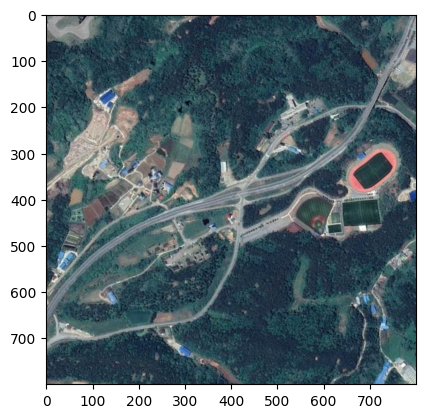

In [18]:
# cv2 compare with ovdsat for specific image
transform = transforms.Compose([
    transforms.Resize((602, 602)),
    Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
])

img_path = '/home/gridsan/manderson/ovdsat/data/dior/JPEGImages/17635.jpg' #12523.jpg 09249.jpg 04325.jpg 02112.jpg
#img_path = '/home/gridsan/manderson/ovdsat/data/cropped_data/dior/val/dior_val-1/Expressway-Service-area/12974_24414.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
plt.imshow(img.permute(1, 2, 0))
# print(img.shape)
# print(img.dtype)
# print(img.mean())
# print(img[:5,:5,:5])
img = transform(img)
print(img.shape)
print(img.mean())
print(img.std())
#print(img[:5,:5,:5])

In [19]:
# what ovdsat is doing now

from torchvision import transforms as T

PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]
coop_normalize = Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)

image = cv2.imread(img_path)
# image_test = image[:, :, [2, 1, 0]]
# print(image_test.shape)
# print(image_test.mean())
# print(image_test.std())
# print(image_test[:5,:5,1])

# ovdsat does this
val_augmentations = A.Compose([
    A.Resize(602,602), # TODO change for CoOp comparison
])

# transform = transforms.Compose([
#     transforms.Resize(
#         size=(602, 602),
#         interpolation=InterpolationMode.BICUBIC,
#         antialias=True,   # matches antialias=warn behavior in newer torchvision
#     ),]
    
transformed = val_augmentations(image=image)
image = torch.as_tensor(transformed['image'].astype("float32").transpose(2, 0, 1))
# print(image.shape)
        
# image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)) 
# resize_transform = T.Resize((602, 602))
# image = resize_transform(image)

image = image[[2, 1, 0], :, :] # Change to RGB
# TODO divide by 255 here
normalized_tensor = coop_normalize(image/255.0)
print(normalized_tensor.shape)

print(normalized_tensor.mean())
print(normalized_tensor.std())
print(normalized_tensor[0,:5,:5])

img = normalized_tensor

torch.Size([3, 602, 602])
tensor(-0.4595)
tensor(0.6489)
tensor([[-0.4200, -0.3178, -0.2010, -0.4054, -0.7120],
        [-0.3178, -0.2740, -0.1572, -0.2448, -0.4200],
        [-0.1718, -0.2010, -0.1280, -0.0988, -0.1572],
        [-0.0988, -0.1426, -0.1134, -0.0696, -0.0696],
        [-0.0550, -0.0405, -0.0405, -0.0113, -0.0259]])


In [ ]:
# # what coop does
# from torchvision.transforms import InterpolationMode

# image = Image.open(img_path).convert("RGB") # what CoOp does
# # image_test2 = np.array(image)
# # print(image_test2.shape)
# # print(image_test2.mean())
# # print(image_test2.std())
# # print(image_test2[:5,:5,1])

# # Is the the same?
# # image = cv2.imread(img_path)
# # print(image.shape)
# # image = image[:, :,[2, 1, 0]]
# # #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # fix channel order
# # image = Image.fromarray(image)

# transform = transforms.Compose([
#     transforms.Resize(
#         size=(602, 602),
#         interpolation=InterpolationMode.BICUBIC,
#         antialias=True,   # matches antialias=warn behavior in newer torchvision
#     ),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.48145466, 0.4578275, 0.40821073],
#         std=[0.26862954, 0.26130258, 0.27577711],
#     ),
# ])

# image = transform(image)
# print(image.shape)
# print(image.mean())
# print(image.std())
# print(image[:5,:5,0])

In [ ]:
# # Match CoOp to ovdsat?
# image = Image.open(img_path).convert("RGB") # what CoOp does, but shouldn't be different

# # What ovdsat does
# val_augmentations = A.Compose([
#     A.Resize(602, 602),
# ])
# transformed = val_augmentations(image=np.array(image))
# image = torch.as_tensor(transformed['image'].astype("float32").transpose(2, 0, 1))
# image = image[[2, 1, 0], :, :]
# normalized_tensor2 = coop_normalize(image/255.0)

# # img = torch.as_tensor(np.array(image).astype("float32").transpose(2, 0, 1)) 
# # resize_transform = T.Resize((224, 224))
# # img = resize_transform(img)
# # img = img[[2, 1, 0], :, :]
# # normalized_tensor = coop_normalize(img/255.0)

# print(normalized_tensor2.shape)
# print(normalized_tensor2.mean())
# print(normalized_tensor2.std())
# print(normalized_tensor2[0,:5,:5])

In [ ]:
#np.array_equal(normalized_tensor, normalized_tensor2) # loading with pil vs cv2 is the same, just need to reorder channels!!!

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
images = img.unsqueeze(0)

patch_size = 14
num_tiles_side = 3 # TODO change from 3 to 1 for CoOp comparison
tile_size = 224
image_size = 602 # TODO change from 602 to 224 for CoOp comparison
B = len(images)
D = 768

# Create full image features tensor and a counter for aggregation
output_features = torch.zeros((B, image_size // patch_size, image_size // patch_size, D)).to(device)
count_tensor = torch.zeros((B, image_size // patch_size, image_size // patch_size,)).to(device)

# Process tiles through CLIP
with torch.no_grad():
    for i in range(num_tiles_side):
        for j in range(num_tiles_side):
            
            print('\nNEW TILE')

            # Update tile coords
            start_i = i * tile_size
            start_j = j * tile_size
            end_i = min(start_i + tile_size, image_size)
            end_j = min(start_j + tile_size, image_size)

            # If tile exceeds, make new tile containing more image content
            if end_i - start_i < tile_size:
                start_i = end_i - tile_size
            if end_j - start_j < tile_size:
                start_j = end_j - tile_size

            # Extract the tile from the original image
            tile = images[:, :, start_i:end_i, start_j:end_j]
            
            print('tile.shape')
            print(tile.shape)
            print(tile[0,0,:5,:5])

            # Get clip visual feats
            image_features = model.to(device).visual(tile.type(model.dtype).to(device)).unsqueeze(1)
            print('image features before norm')
            print(image_features.shape)
            print(image_features.mean())
            print(image_features.std())
            print(image_features[0,0,:10])

            _, K, D = image_features.shape
            #print(K, D)
            p_w = p_h = int(K**0.5)
            #print(p_w, p_h)
            image_features = image_features.reshape(B, p_h, p_w, -1)  # Reshape to 2D
            #print(image_features.shape)
            #print(image_features)

            #print(end_i // patch_size)
            # Add features to their location in the original image and track counts per location
            output_features[:, start_i // patch_size:end_i // patch_size, start_j // patch_size:end_j // patch_size] += image_features
            count_tensor[:, start_i // patch_size:end_i // patch_size, start_j // patch_size:end_j // patch_size] += 1

# Average the overlapping patches
output_features /= count_tensor.unsqueeze(-1)


NEW TILE
tile.shape
torch.Size([1, 3, 224, 224])
tensor([[-0.4200, -0.3178, -0.2010, -0.4054, -0.7120],
        [-0.3178, -0.2740, -0.1572, -0.2448, -0.4200],
        [-0.1718, -0.2010, -0.1280, -0.0988, -0.1572],
        [-0.0988, -0.1426, -0.1134, -0.0696, -0.0696],
        [-0.0550, -0.0405, -0.0405, -0.0113, -0.0259]])
image features before norm
torch.Size([1, 1, 768])
tensor(0.0067, device='cuda:0', dtype=torch.float16)
tensor(0.7012, device='cuda:0', dtype=torch.float16)
tensor([ 0.0202,  0.0055, -0.2749, -0.0309, -0.0028,  0.2098,  0.2988, -1.0410,
        -0.2061,  0.0510], device='cuda:0', dtype=torch.float16)

NEW TILE
tile.shape
torch.Size([1, 3, 224, 224])
tensor([[-0.9310, -0.8288, -1.1061, -1.1937, -0.8726],
        [-1.0185, -1.0039, -0.9310, -0.7412, -0.4638],
        [-1.1353, -1.1499, -0.6390, -0.2448, -0.1864],
        [-0.9018, -0.6244,  0.0471,  0.2077, -0.1134],
        [-0.5076, -0.0550,  0.4267,  0.3099, -0.0696]])
image features before norm
torch.Size([1, 1, 7

In [9]:
print(output_features.min())
print(output_features.max())
print(output_features.mean())

tensor(-8.0234, device='cuda:0')
tensor(8.6172, device='cuda:0')
tensor(0.0074, device='cuda:0')


In [10]:
print(output_features.shape)
print(output_features[0,:5,:5,0])
# At 16 we see it change so it replicates the 1x768 embedding for each 224x224 tile
print(output_features[0,15:20,15:20,0])
print(output_features[0,20:25,20:25,0])

torch.Size([1, 43, 43, 768])
tensor([[0.3860, 0.3860, 0.3860, 0.3860, 0.3860],
        [0.3860, 0.3860, 0.3860, 0.3860, 0.3860],
        [0.3860, 0.3860, 0.3860, 0.3860, 0.3860],
        [0.3860, 0.3860, 0.3860, 0.3860, 0.3860],
        [0.3860, 0.3860, 0.3860, 0.3860, 0.3860]], device='cuda:0')
tensor([[0.3860, 0.2742, 0.2742, 0.2742, 0.2742],
        [0.1836, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.1836, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.1836, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.1836, 0.2751, 0.2751, 0.2751, 0.2751]], device='cuda:0')
tensor([[0.2751, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.2751, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.2751, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.2751, 0.2751, 0.2751, 0.2751, 0.2751],
        [0.2751, 0.2751, 0.2751, 0.2751, 0.2751]], device='cuda:0')


In [11]:
print(output_features[0,1,1,:10])
print(output_features[0,2,1,:10])
print(output_features[0,15,1,:10])
print(output_features[0,16,1,:10])

tensor([ 0.3860,  0.3762,  0.2404,  0.5381,  0.2007,  0.6558,  1.1387, -0.3923,
         0.3633, -0.0326], device='cuda:0')
tensor([ 0.3860,  0.3762,  0.2404,  0.5381,  0.2007,  0.6558,  1.1387, -0.3923,
         0.3633, -0.0326], device='cuda:0')
tensor([ 0.3860,  0.3762,  0.2404,  0.5381,  0.2007,  0.6558,  1.1387, -0.3923,
         0.3633, -0.0326], device='cuda:0')
tensor([ 0.1836, -0.6455,  0.2338,  0.1414, -0.0303,  0.3057,  1.0322, -0.4792,
        -0.0942,  0.0983], device='cuda:0')


In [24]:
feats = output_features.view(output_features.shape[0], -1, output_features.shape[-1])
print(feats.shape)

embeddings = text_norm
batch_size = 100

num_feats = feats.shape[0]
num_classes = embeddings.shape[0]
patch_2d_size = int(np.sqrt(feats.shape[1]))

cosim_list = []
for start_idx in range(0, num_classes, batch_size):
    print('start_idx')
    print(start_idx)
    end_idx = min(start_idx + batch_size, num_classes) #num_classes=20
    print('end_idx')
    print(end_idx)

    embedding_batch = embeddings[start_idx:end_idx]  # Get a batch of embeddings
    print(embedding_batch.shape)

    ### Modified to exactly match CLIP cosine similarity in CoOp
    feat_norm = (feats / feats.norm(dim=-1, keepdim=True))
    embed_norm = embedding_batch / embedding_batch.norm(dim=-1, keepdim=True)
    
    print('\ndebug text embedding norm mean')
    print(embed_norm.shape)
    print(embed_norm.mean())
    print(embed_norm.std())
    print(embed_norm[0,:10])

    print('\ndebug image embedding norm mean')
    print(feat_norm.shape)
    print(feat_norm.mean())
    print(feat_norm.std())
    print(feat_norm[0,0,:10])

    feat_norm = feat_norm.float().to(device)
    embed_norm = embed_norm.float().to(device)

    dot_product = (feat_norm @ embed_norm.t())
    sim = dot_product
    print('\nDEBUG sim')
    print(sim.shape)
    print(sim.mean())
    print(sim.std())
    print(sim[0,0,:])
    dot_product = dot_product.transpose(1, 2)

    print('logit_scale')
    print(model.logit_scale.exp())
    dot_product *= model.logit_scale.exp() # REMOVE FOR NOW?
    print('\ndot_product')
    print(dot_product.shape)
    
    print('\nlogits')
    logits = dot_product
    print(logits.shape)
    print(logits.mean())
    print(logits.std())
    print(logits[:,:,0])
    
    # softmax?
    dot_product = dot_product.softmax(dim=1)
    print('\nlogits (after softmax)')
    print(dot_product.shape)
    
    print('min and max')
    print(dot_product.min())
    print(dot_product.max())

    # Append the similarity scores for this batch to the list
    cosim_list.append(dot_product)

# Concatenate the similarity scores from different batches
cosim = torch.cat(cosim_list, dim=1)

print('\ncosim min and max')
print(cosim.min())
print(cosim.max())

# Reshape to 2D and return class similarity maps
cosim = cosim.reshape(-1, num_classes, patch_2d_size, patch_2d_size)
print('cosim')
print(cosim.shape)

# Interpolate cosine similarity maps to original resolution
cosim = F.interpolate(cosim, size=602, mode='bicubic') # try bilinear instead of bicubic?
print(cosim.shape)

#print(cosim[0,:5,:5,:5])

torch.Size([1, 1849, 768])
start_idx
0
end_idx
20
torch.Size([20, 768])

debug text embedding norm mean
torch.Size([20, 768])
tensor(-0.0010, dtype=torch.float16)
tensor(0.0362, dtype=torch.float16)
tensor([ 0.0052,  0.0837,  0.0573,  0.0071, -0.0211,  0.0358,  0.0296, -0.0189,
         0.0436, -0.0234], dtype=torch.float16)

debug image embedding norm mean
torch.Size([1, 1849, 768])
tensor(-3.4371e-05, device='cuda:0')
tensor(0.0361, device='cuda:0')
tensor([ 0.0010,  0.0003, -0.0142, -0.0016, -0.0001,  0.0108,  0.0154, -0.0536,
        -0.0106,  0.0026], device='cuda:0')

DEBUG sim
torch.Size([1, 1849, 20])
tensor(0.1170, device='cuda:0')
tensor(0.0471, device='cuda:0')
tensor([0.1918, 0.1584, 0.0589, 0.1194, 0.1008, 0.0995, 0.1409, 0.1613, 0.2171,
        0.1714, 0.1147, 0.1057, 0.0655, 0.0953, 0.1280, 0.1114, 0.0486, 0.0926,
        0.0882, 0.1336], device='cuda:0')
logit_scale
tensor(99.7623, device='cuda:0', grad_fn=<ExpBackward0>)

dot_product
torch.Size([1, 20, 1849])

logits
t

In [78]:
# Same for everything in that tile
print(sim[0,0,:])
print(sim[0,1,:])
print(sim[0,2,:])

tensor([16.4695,  9.9864,  9.3604, 13.7562, 15.3290, 14.6754, 17.5249, 19.4569,
        16.4832, 14.6929, 24.0579, 13.2740, 17.9266, 17.6695, 22.2758, 16.9960,
        12.5392, 18.7551, 12.6024,  8.7860], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([16.4695,  9.9864,  9.3604, 13.7562, 15.3290, 14.6754, 17.5249, 19.4569,
        16.4832, 14.6929, 24.0579, 13.2740, 17.9266, 17.6695, 22.2758, 16.9960,
        12.5392, 18.7551, 12.6024,  8.7860], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([16.4695,  9.9864,  9.3604, 13.7562, 15.3290, 14.6754, 17.5249, 19.4569,
        16.4832, 14.6929, 24.0579, 13.2740, 17.9266, 17.6695, 22.2758, 16.9960,
        12.5392, 18.7551, 12.6024,  8.7860], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [97]:
print(cosim.min())
print(cosim.max())

tensor(-0.1059, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0510, device='cuda:0', grad_fn=<MaxBackward1>)


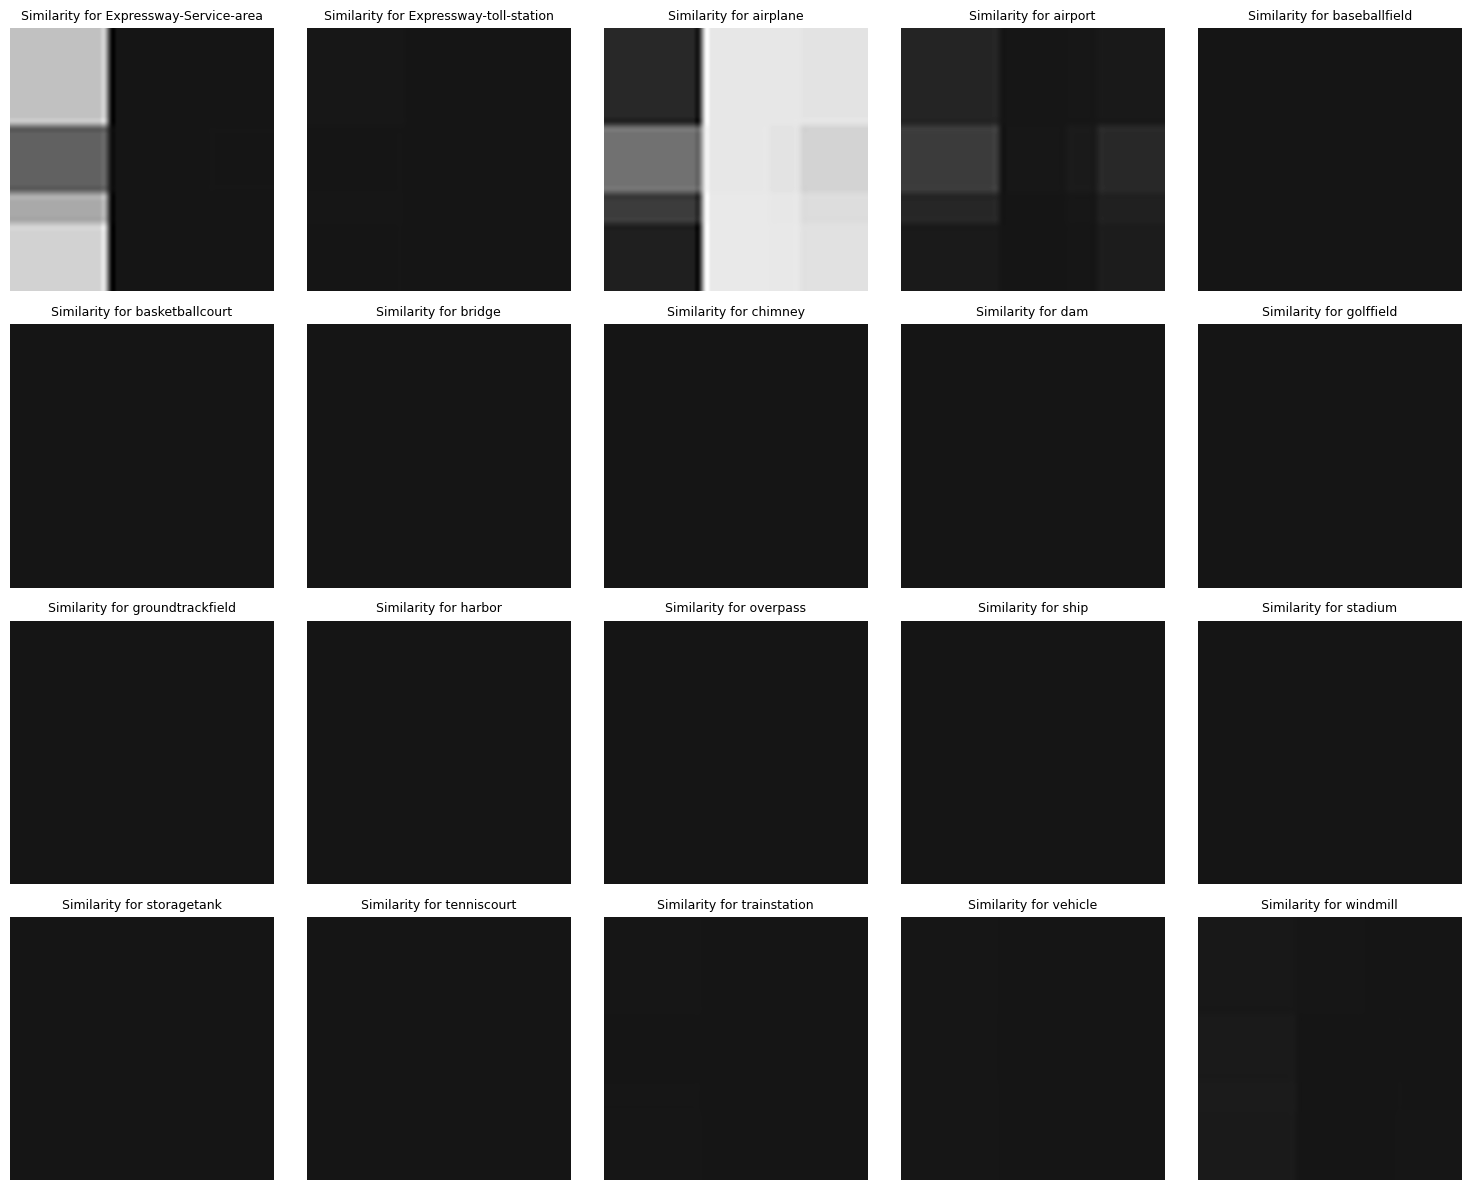

In [119]:
# Visualize cosim

# remove batch dimension -> [20, 602, 602]
maps = cosim.squeeze(0)  
num_channels = maps.shape[0]

# compute global min/max across all maps
global_min = maps.min().item()
global_max = maps.max().item()

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(num_channels):
    fmap = maps[i].detach().cpu().numpy()
    axes[i].imshow(fmap, cmap="gray", vmin=global_min, vmax=global_max)
    axes[i].set_title(f"Similarity for {coop_labels[i]}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

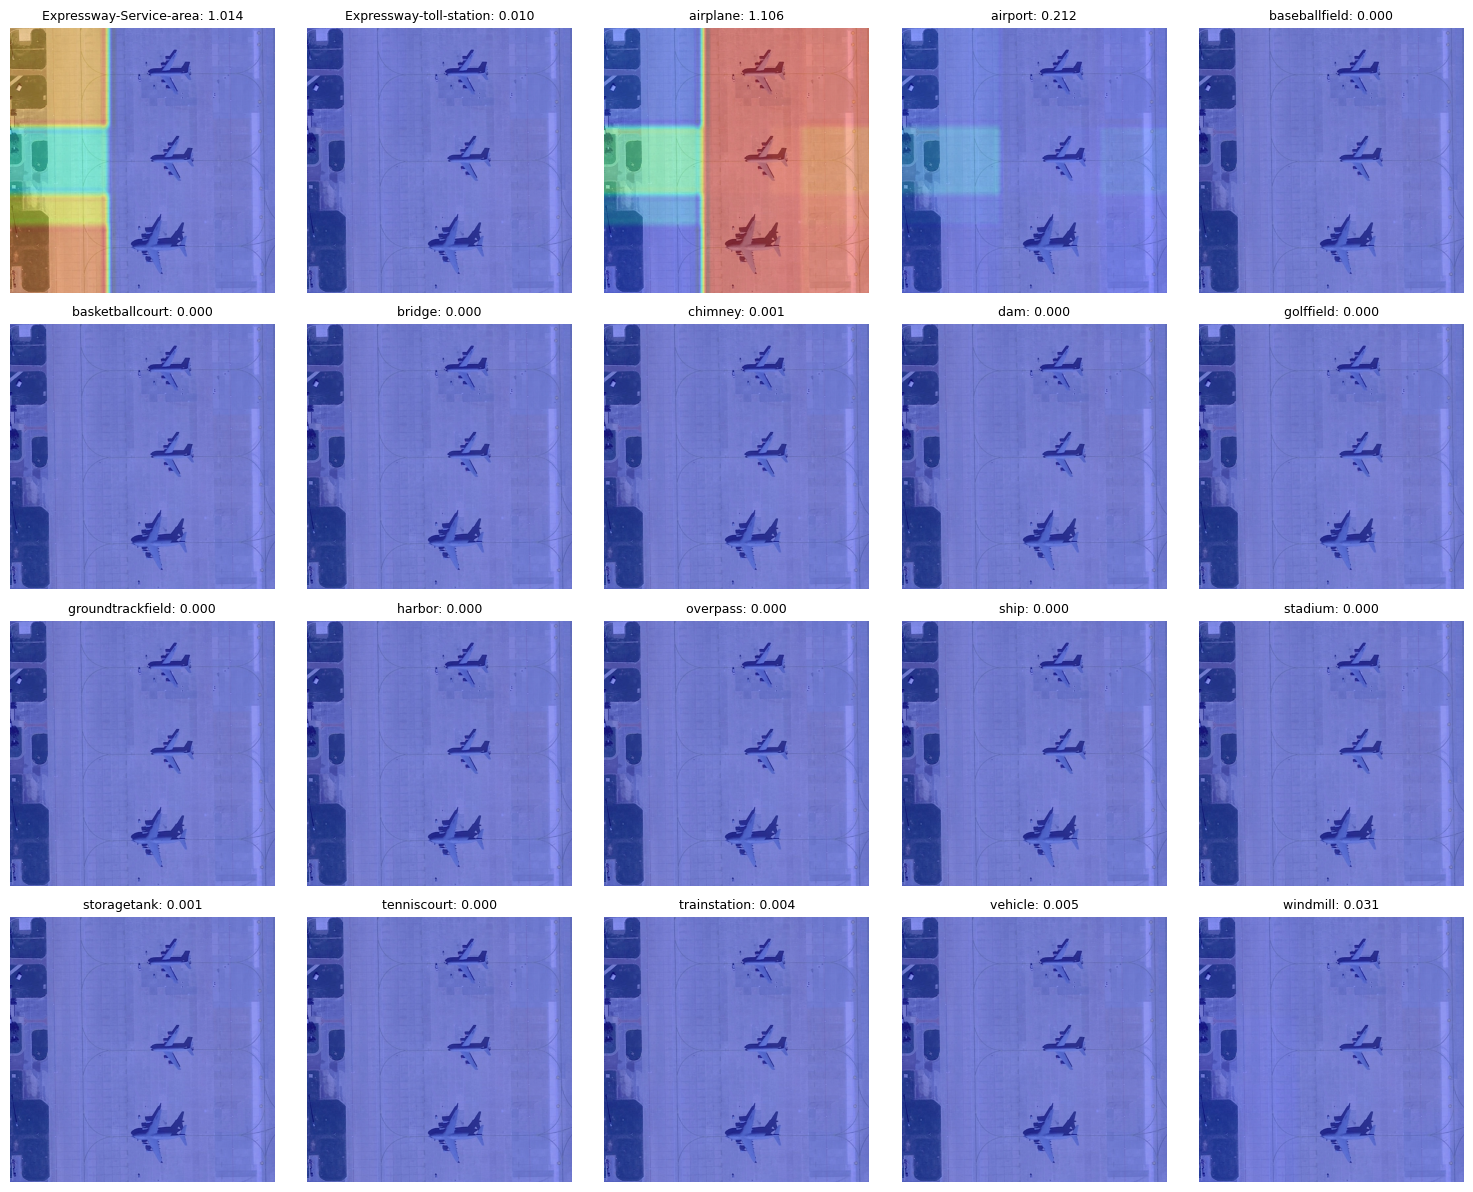

In [120]:
img_np = img.permute(1, 2, 0).detach().cpu().numpy()
img_vis = img_np.copy()
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

global_min = maps.min().item()
global_max = maps.max().item()

for i in range(maps.shape[0]):
    ax = axes[i]
    fmap = maps[i].detach().cpu().numpy()

    ax.imshow(img_vis)
    ax.imshow(fmap, cmap="jet", alpha=0.4, vmin=global_min, vmax=global_max)
    ax.set_title(f'{coop_labels[i]}: {fmap.max():.3f}' , fontsize=9)
    #ax.set_xlabel(f"max={fmap.max():.3f}", fontsize=7)
    ax.axis("off")

plt.tight_layout(pad=1.0)
plt.show()

In [ ]:
# # Get proposal boxes
# from models.rpn.box_rpn import BoxRPN
# rpn_config='configs/FasterRCNN_FPN_DOTA_config.yaml'
# rpn_checkpoint='weights/FasterRCNN_FPN_DOTA_final_model.pth'
# rpn = BoxRPN(rpn_config, rpn_checkpoint)

# device = next(rpn.parameters()).device
# images = images.to(device)
# proposals, proposals_scores = rpn(images)

In [ ]:
# print(proposals.shape)
# print(proposals_scores.shape)
# proposals_scores.mean() # all negative -> very low confidence

**Maybe this means that the image processing for the RPN needs to be what it was originally in ovdsat to work**

In [121]:
from models.rpn.box_rpn import BoxRPN
rpn_config='configs/FasterRCNN_FPN_DOTA_config.yaml'
rpn_checkpoint='weights/FasterRCNN_FPN_DOTA_final_model.pth'
rpn = BoxRPN(rpn_config, rpn_checkpoint)

# try loading like original
# cv2 compare with ovdsat for specific image
transform = transforms.Compose([
    transforms.Resize((602, 602)),
])

rpn_img = cv2.imread(img_path)
rpn_img = torch.as_tensor(rpn_img.astype("float32").transpose(2, 0, 1))
#plt.imshow(rpn_img.permute(1, 2, 0))
# print(img.shape)
# print(img.dtype)
# print(img.mean())
# print(img[:5,:5,:5])
rpn_img = transform(rpn_img)


# # ovdsat does this
# image = cv2.imread(img_path)
# val_augmentations = A.Compose([
#     A.Resize(602, 602, interpolation=cv2.INTER_CUBIC),
# ])

# # transform = transforms.Compose([
# #     transforms.Resize(
# #         size=(602, 602),
# #         interpolation=InterpolationMode.BICUBIC,
# #         antialias=True,   # matches antialias=warn behavior in newer torchvision
# #     ),]
    
# transformed = val_augmentations(image=image)
# rpn_img = torch.as_tensor(transformed['image'].astype("float32").transpose(2, 0, 1))


print(rpn_img.shape)
print(rpn_img.mean())
print(rpn_img[:5,:5,:5])

torch.Size([3, 602, 602])
tensor(185.6965)
tensor([[[151.2753, 159.4646, 158.9548, 159.3755, 164.6834],
         [146.4529, 152.3894, 153.3505, 153.3432, 152.8048],
         [123.7538, 124.7804, 125.9070, 127.1861, 123.0027],
         [128.4818, 125.2809, 126.2179, 128.0245, 125.4231],
         [126.5798, 124.0005, 125.9666, 125.2430, 120.7105]],

        [[160.2753, 168.4646, 167.9548, 168.3755, 173.6834],
         [155.4529, 161.3894, 162.3505, 162.3432, 161.8049],
         [132.7538, 133.7804, 134.9070, 136.1861, 132.0027],
         [137.4818, 134.2809, 135.2179, 137.0245, 134.4231],
         [135.5798, 133.0005, 134.9666, 134.2430, 129.7105]],

        [[150.2753, 158.4646, 157.9548, 158.3755, 163.6834],
         [145.4529, 151.3894, 152.3505, 152.3432, 151.8049],
         [122.7538, 123.7804, 124.9070, 126.1861, 122.0027],
         [127.4818, 124.2809, 125.2179, 127.0245, 124.4231],
         [125.5798, 123.0005, 124.9666, 124.2430, 119.7105]]])


In [122]:
device = next(rpn.parameters()).device
rpn_img = rpn_img.unsqueeze(0).to(device)
proposals, proposals_scores = rpn(rpn_img)

In [123]:
print(proposals.shape)
print(proposals_scores.shape)
print(proposals_scores.min())
print(proposals_scores.max())
# proposals_scores = proposals_scores.softmax(dim=1)
# print(proposals_scores.shape)
# print(proposals_scores.min())
# print(proposals_scores.max())

torch.Size([1, 1000, 4])
torch.Size([1, 1000])
tensor(-0.9054, device='cuda:0')
tensor(0.8383, device='cuda:0')


In [124]:
print(proposals[0, :5])
print()
print(proposals_scores[0, :20])

tensor([[266.4188, 422.4595, 416.9163, 573.5012],
        [310.3934, 243.9151, 431.7447, 352.4894],
        [301.4755,  44.2176, 421.2534, 156.6599],
        [  1.2387, 187.8655,  15.0284, 196.3066],
        [289.6873, 104.2679, 297.5608, 122.9531]], device='cuda:0')

tensor([0.8383, 0.8013, 0.7947, 0.6342, 0.6105, 0.5868, 0.5535, 0.5508, 0.5486,
        0.5356, 0.5320, 0.5147, 0.4962, 0.4906, 0.4852, 0.4636, 0.4126, 0.3977,
        0.2982, 0.2871], device='cuda:0')


In [125]:
# From classifier

boxes = proposals
cosine_sim = cosim

cls = None
aggregation='mean'
num_classes = len(coop_labels)

# Gather similarity values inside each box and compute average box similarity
box_similarities = []
B = images.shape[0]
for b in range(B):
    image_boxes = boxes[b][:, :4]

    image_similarities = []
    count = 0
    for i, box in enumerate(image_boxes):
        x_min, y_min, x_max, y_max = box.int()

        # if cls is not None:
        #     if (x_min < 0 or
        #         y_min < 0 or
        #         y_max > self.target_size[0] or
        #         x_max > self.target_size[0] or
        #         y_max - y_min < self.min_box_size or
        #         x_max - x_min < self.min_box_size):
        #         count += 1
        #         cls[b][i] = self.ignore_index   # If invalid box, assign the label to ignore it while computing the loss
        #         image_similarities.append(torch.zeros(self.num_classes, device=images.device))
        #         continue

        if aggregation == 'mean':
            box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max].mean(dim=[1, 2])
        elif aggregation == 'max':
            _,n,h,w = cosine_sim.shape
            box_sim, _ = cosine_sim[b, :, y_min:y_max - 1, x_min:x_max - 1].reshape(n, -1).max(dim=1)
        elif aggregation == 'topk':
            _,n,h,w = cosine_sim.shape
            box_sim = cosine_sim[b, :, y_min:y_max - 1, x_min:x_max - 1].reshape(n, -1)
            topk = k if k <= box_sim.shape[1] else box_sim.shape[1]
            box_sim, _ = box_sim.topk(topk, dim=1)
            box_sim = box_sim.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation method')

        has_nan = torch.isnan(box_sim).any().item()
        image_similarities.append(box_sim)

    box_similarities.append(torch.stack(image_similarities))

box_similarities = torch.stack(box_similarities)  # Shape: [B, max_boxes, N]

# Flatten box_logits and target_labels
box_similarities = box_similarities.view(B, -1, num_classes)

In [126]:
print(boxes[0,0])
print(box_similarities.shape)
box_similarities[0,0]

tensor([266.4188, 422.4595, 416.9163, 573.5012], device='cuda:0')
torch.Size([1, 1000, 20])


tensor([1.7657e-05, 1.0758e-06, 9.9737e-01, 1.8206e-03, 1.6102e-06, 2.9626e-06,
        2.5790e-07, 1.0397e-05, 6.0781e-06, 6.5795e-06, 1.8635e-05, 1.3498e-05,
        1.9043e-06, 2.7882e-05, 7.6626e-07, 1.5929e-05, 3.2318e-06, 7.8155e-06,
        4.3630e-06, 6.6806e-04], device='cuda:0', grad_fn=<SelectBackward0>)

In [127]:
print(box_similarities[0,0].min())
print(box_similarities[0,0].max())

tensor(2.5790e-07, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.9974, device='cuda:0', grad_fn=<MaxBackward1>)


In [106]:
# # Try specific box

# x_min = 263
# y_min = 65
# x_max = 602
# y_max = 466

# box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max]
# print(box_sim.shape)

# box_sim = box_sim.mean(dim=[1, 2])
# print(box_sim.shape)

# print(box_sim)

In [ ]:
# boxes + viz (don't need to run)

# box_similarities = []
# B = images.shape[0]

# for b in range(B):
#     image_boxes = boxes[b][:, :4]
#     img_np = images[b].permute(1, 2, 0).detach().cpu().numpy()
#     if img_np.max() > 1:  # normalize if 0–255
#         img_np = img_np / 255.0

#     image_similarities = []
#     for i, box in enumerate(image_boxes):
#         x_min, y_min, x_max, y_max = [int(v.item()) for v in box]

#         # --- your aggregation logic ---
#         if aggregation == 'mean':
#             box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max].mean(dim=[1, 2])
#         elif aggregation == 'max':
#             _, n, h, w = cosine_sim.shape
#             box_sim, _ = cosine_sim[b, :, y_min:y_max, x_min:x_max].reshape(n, -1).max(dim=1)
#         elif aggregation == 'topk':
#             _, n, h, w = cosine_sim.shape
#             region = cosine_sim[b, :, y_min:y_max, x_min:x_max].reshape(n, -1)
#             topk = min(k, region.shape[1])
#             box_sim, _ = region.topk(topk, dim=1)
#             box_sim = box_sim.mean(dim=1)
#         else:
#             raise ValueError('Invalid aggregation method')

#         image_similarities.append(box_sim)
        
#         #print(f"Box {i}: ({x_min}, {y_min}, {x_max}, {y_max}) -> {label} ({score:.3f})")

#         # --- visualization: show this box on its own ---
#         max_score, best_class = torch.max(box_sim, dim=0)
#         label = coop_labels[best_class.item()]
#         score = max_score.item()

#         fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#         ax.imshow(img_vis)

#         # draw rectangle
#         rect = patches.Rectangle(
#             (x_min, y_min), x_max - x_min, y_max - y_min,
#             linewidth=2, edgecolor='red', facecolor='none'
#         )
#         ax.add_patch(rect)

#         # add label + score
#         ax.text(
#             x_min, max(y_min - 5, 0),
#             f"{label}: {score:.2f}",
#             color="yellow", fontsize=8, weight="bold",
#             bbox=dict(facecolor="black", alpha=0.5, pad=1)
#         )
#         plt.show()

#     box_similarities.append(torch.stack(image_similarities))

# box_similarities = torch.stack(box_similarities)  # [B, max_boxes, N]


In [50]:
def filter_boxes(boxes, classes, scores, target_size, num_labels, box_conf_threshold=0):
    print(box_conf_threshold)
    
    print('in filter_boxes')
    target_height, target_width = target_size
    keep = ((boxes[:, 0] >= 0) & (boxes[:, 1] >= 0) &
            (boxes[:, 2] <= target_width) & (boxes[:, 3] <= target_height))
    
    print(boxes.shape)

    filtered_boxes = boxes[keep]
    filtered_classes = classes[keep]
    filtered_scores = scores[keep]
    
    print(filtered_boxes.shape)

    # Filter out boxes classified as background
    predictions = torch.argmax(filtered_classes, dim=-1)   
    #print(predictions.shape)
    filtered_boxes = filtered_boxes[predictions < num_labels, ...]
    filtered_classes = filtered_classes[predictions < num_labels, ...]
    filtered_scores = filtered_scores[predictions < num_labels]
    
    print(filtered_boxes.shape)
    
    # Filter out boxes with low confidence
    keep = filtered_scores > box_conf_threshold
    filtered_boxes = filtered_boxes[keep, ...]
    filtered_classes = filtered_classes[keep, ...]
    filtered_scores = filtered_scores[keep]
    
    print(filtered_boxes.shape)
    
    print('done')


    return filtered_boxes, filtered_classes[:, :num_labels], filtered_scores

In [128]:
#0.001 0.2 300
import time
import torchvision

def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
        isdino=True,
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """
    
    print('NMS debug')
    print(conf_thres, iou_thres, max_det)
    print(prediction.shape)

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    #xc = prediction[..., 4] > conf_thres  # candidates - it ends up filtering out any boxes < conf_thres
    xc = prediction[..., 4] > 0

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    mi = 5 + nc  # mask start index
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence
        print('x')
        print(x.shape)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        #if not isdino:
        x[:, 5:] *= x[:, 4:5]  # conf = class_conf * box_conf
        print('compute conf')
        print(x[:, 5:].shape)
        print(x[:, 4:5].shape)

        # Box/Mask
        if isdino:
            box = x[:, :4]
        else:
            box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            print('in best class only')
            conf, j = x[:, 5:mi].max(1, keepdim=True)
            print(conf)
            # # CHANGE conf_thres
            # conf_thres = 10
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]
            print(x.shape)

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            #LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            break  # time limit exceeded

    return output

In [129]:
# From detector

#from utils_dir.processing_utils import filter_boxes
#from utils_dir.nms import non_max_suppression

target_size = (602,602)
num_classes = 20
box_conf_threshold = 0.01 # just for initial box filter, should be >= conf_thres since conf_thres does this too
iou_thr = 0.2
conf_thres = 0.1#0.05 # CHANGE? original 0.001 this ends up initially filtering boxes in NMS

B, num_proposals = proposals_scores.shape
print('B', B)
print('num_proposals', num_proposals)
preds = box_similarities

# if num_proposals == 0:
#     return [torch.tensor([], device=images.device) for _ in range(B)]

# Extract class scores and predicted classes
preds = preds.reshape(B, num_proposals, -1)
print(preds.shape)
scores, _ = torch.max(preds, dim=-1)
print(scores.shape)
classes = torch.argmax(preds, dim=-1)
print(classes.shape)

# Filter predictions and prepare for NMS
processed_predictions = []
for b in range(B):
    # Filter and prepare boxes for NMS
    print('proposals.shape')
    print(proposals.shape)
    filtered_boxes, filtered_classes, filtered_scores = filter_boxes(proposals[b].cpu(),
                                                                    preds[b].cpu(), # class scores
                                                                    proposals_scores[b].cpu(),
                                                                    target_size,
                                                                    num_classes,
                                                                    box_conf_threshold)
    print('filtered_boxes.shape')
    print(filtered_boxes.shape)
    print(filtered_boxes[0])
    print('filtered_scores.shape')
    print(filtered_scores.shape)
    pred_boxes_with_scores = torch.cat([filtered_boxes, filtered_scores[:, None], filtered_classes], dim=1)
    print('pred_boxes_with_scores.shape')
    print(pred_boxes_with_scores.shape) # first 4 are box coorindates, 5th is the box score, rest are class scores

    # Use the cosine similarity class score as box confidence scores
    max_cls_scores, _ = torch.max(filtered_classes, dim=-1)
    sorted_indices = torch.argsort(filtered_scores, descending=True)
    pred_boxes_with_scores = pred_boxes_with_scores[sorted_indices]
    print(pred_boxes_with_scores.shape)

    print()
    # Apply non maximum suppression
    nms_results = non_max_suppression(pred_boxes_with_scores.unsqueeze(0), iou_thres=iou_thr, conf_thres=conf_thres) 
    # In NMS it takes object conf * class conf!!!
    processed_predictions.append(nms_results[0])

B 1
num_proposals 1000
torch.Size([1, 1000, 20])
torch.Size([1, 1000])
torch.Size([1, 1000])
proposals.shape
torch.Size([1, 1000, 4])
0.01
in filter_boxes
torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([60, 4])
done
filtered_boxes.shape
torch.Size([60, 4])
tensor([266.4188, 422.4595, 416.9163, 573.5012])
filtered_scores.shape
torch.Size([60])
pred_boxes_with_scores.shape
torch.Size([60, 25])
torch.Size([60, 25])

NMS debug
0.1 0.2 300
torch.Size([1, 60, 25])
x
torch.Size([60, 25])
compute conf
torch.Size([60, 20])
torch.Size([60, 1])
in best class only
tensor([[0.8361],
        [0.7879],
        [0.7869],
        [0.5132],
        [0.6044],
        [0.4749],
        [0.2470],
        [0.5454],
        [0.5432],
        [0.5303],
        [0.4305],
        [0.2331],
        [0.2184],
        [0.3970],
        [0.2191],
        [0.2083],
        [0.3339],
        [0.3218],
        [0.2413],
        [0.1296],
        [0.2154],
        [0.1102],
        [0.1129

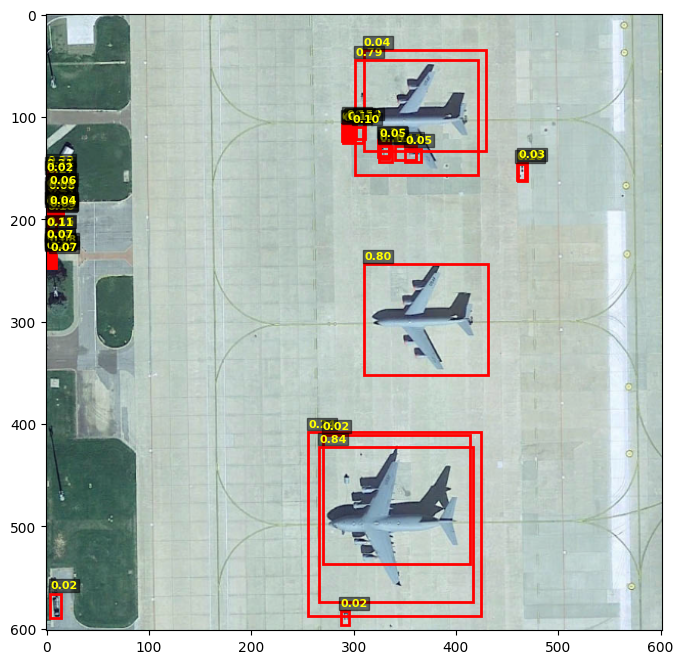

In [130]:
# Visualize the filtered boxes
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_vis)

i = 0
for box in filtered_boxes:
    score = filtered_scores[i]
    x1, y1, x2, y2 = box

    # draw rectangle
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # add label and score
    ax.text(
        x1, max(y1 - 5, 0),
        f"{score:.2f}",
        color="yellow", fontsize=8, weight="bold",
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )
    i += 1

plt.show()

In [131]:
print(filtered_scores)

tensor([0.8383, 0.8013, 0.7947, 0.6342, 0.6105, 0.5868, 0.5535, 0.5508, 0.5486,
        0.5356, 0.5320, 0.5147, 0.4962, 0.4906, 0.4852, 0.4636, 0.4126, 0.3977,
        0.2982, 0.2871, 0.2662, 0.2531, 0.2484, 0.2460, 0.2369, 0.2348, 0.2169,
        0.2101, 0.1917, 0.1619, 0.1543, 0.1531, 0.1504, 0.1455, 0.1436, 0.1393,
        0.1113, 0.1088, 0.1079, 0.1021, 0.1004, 0.0995, 0.0985, 0.0973, 0.0885,
        0.0884, 0.0842, 0.0805, 0.0747, 0.0735, 0.0586, 0.0522, 0.0477, 0.0405,
        0.0385, 0.0323, 0.0220, 0.0212, 0.0186, 0.0184])


In [132]:
print(pred_boxes_with_scores.shape)

torch.Size([60, 25])


In [133]:
print(pred_boxes_with_scores[0]) # matches!
print()
print(processed_predictions)

tensor([2.6642e+02, 4.2246e+02, 4.1692e+02, 5.7350e+02, 8.3828e-01, 1.7657e-05,
        1.0758e-06, 9.9737e-01, 1.8206e-03, 1.6102e-06, 2.9626e-06, 2.5790e-07,
        1.0397e-05, 6.0781e-06, 6.5795e-06, 1.8635e-05, 1.3498e-05, 1.9043e-06,
        2.7882e-05, 7.6626e-07, 1.5929e-05, 3.2318e-06, 7.8155e-06, 4.3630e-06,
        6.6806e-04], grad_fn=<SelectBackward0>)

[tensor([[2.6642e+02, 4.2246e+02, 4.1692e+02, 5.7350e+02, 8.3607e-01, 2.0000e+00],
        [3.1039e+02, 2.4392e+02, 4.3174e+02, 3.5249e+02, 7.8792e-01, 2.0000e+00],
        [3.0148e+02, 4.4218e+01, 4.2125e+02, 1.5666e+02, 7.8693e-01, 2.0000e+00],
        [2.8969e+02, 1.0427e+02, 2.9756e+02, 1.2295e+02, 6.0443e-01, 2.0000e+00],
        [1.2387e+00, 1.8787e+02, 1.5028e+01, 1.9631e+02, 5.1315e-01, 0.0000e+00],
        [8.1011e-01, 1.6952e+02, 1.1407e+01, 1.8844e+02, 3.9701e-01, 0.0000e+00],
        [0.0000e+00, 2.2878e+02, 3.4966e+00, 2.4225e+02, 2.4697e-01, 2.0000e+00],
        [2.9488e+00, 2.3041e+02, 7.0418e+00, 2.4510e+02,

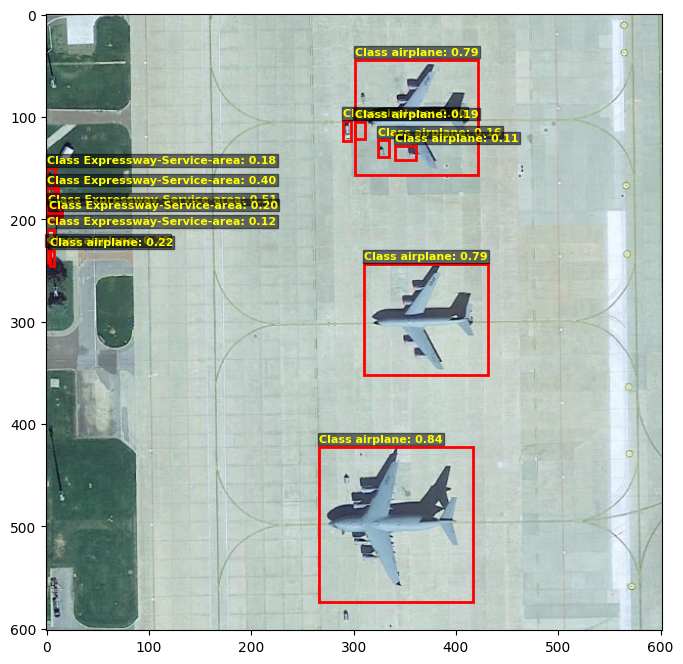

In [134]:
preds = processed_predictions[0].detach().cpu()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_vis)

for box in preds:
    x1, y1, x2, y2, score, label = box.tolist()

    # draw rectangle
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # add label and score
    ax.text(
        x1, max(y1 - 5, 0),
        f"Class {coop_labels[int(label)]}: {score:.2f}",
        color="yellow", fontsize=8, weight="bold",
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )

plt.show()

### Compare with Gt

In [ ]:
# 1. Build index from COCO JSON (run once)
def load_coco(annotations_file):
    with open(annotations_file, "r") as f:
        coco = json.load(f)

    # Map file_name -> image dict
    filename_to_image = {im["file_name"]: im for im in coco["images"]}

    # Map image_id -> list of annotation dicts
    anns_by_id = {}
    for ann in coco["annotations"]:
        anns_by_id.setdefault(ann["image_id"], []).append(ann)

    return filename_to_image, anns_by_id


# 2. Get GT for a single JPEG filename
def get_gt(jpeg_name, root_dir, filename_to_image, anns_by_id, max_boxes=500):
    """
    jpeg_name: "01221.jpg"
    root_dir: folder containing the JPG files
    """
    fname = os.path.basename(jpeg_name)

    # --- image info ---
    img_info = filename_to_image[fname]
    image_id = img_info["id"]
    width = img_info.get("width")
    height = img_info.get("height")
    impath = os.path.join(root_dir, fname)

    # --- annotations ---
    anns = anns_by_id.get(image_id, [])

    boxes = []
    labels = []

    for ann in anns:
        x, y, w, h = ann["bbox"]
        if w < 1 or h < 1:
            continue
        boxes.append([x, y, w, h])
        labels.append(ann["category_id"])

    # --- convert + pad ---
    boxes = np.array(boxes, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    padded_boxes = torch.zeros((max_boxes, 4))
    padded_labels = torch.full((max_boxes,), -1.0)

    n = len(boxes)
    if n > 0:
        padded_boxes[:n] = torch.tensor(boxes)
        padded_labels[:n] = torch.tensor(labels)

    metadata = {
        "width": width,
        "height": height,
        "impath": impath,
    }

    return padded_boxes, padded_labels, metadata

In [ ]:
root_dir = "data/dior/JPEGImages"

M = 1
annotations_file = val_file = f'data/dior/val_coco-{M}.json'

# Build index once
filename_to_image, anns_by_id = load_coco(annotations_file)

# Get GT for a specific JPEG
boxes, labels, metadata = get_gt("02112.jpg", root_dir, filename_to_image, anns_by_id)

print("boxes:", boxes.shape)   # torch.Size([500, 4])
print("labels:", labels.shape) # torch.Size([500])
print("metadata:", metadata)

In [ ]:
for si, pred in enumerate(preds):    
    keep = labels[si] > -1
    targets = labels[si, keep]
    targets_orig = targets.clone()
    nl, npr = targets.shape[0], pred.shape[0]  # number of labels, predictions
    correct = torch.zeros(npr, len(iouv), dtype=torch.bool, device=device)  # init
    seen += 1

    if npr == 0:
        if nl:
            stats.append((correct, *torch.zeros((2, 0), device=device), targets[:]))
        continue

    predn = pred.clone()

    # Reclassify using superclasses
    if sc:
        predn[:,-1] = reclassify(predn[:,-1], sc_cat)

    if nl:
        keep = keep.to(boxes.device)
        tbox = custom_xywh2xyxy(boxes[si, keep, :])  # target boxes
        tbox = tbox.to(targets.device)
        labelsn = torch.cat((targets[..., None], tbox), 1)  # native-space labels
        correct = process_batch(predn, labelsn, iouv)

    stats.append((correct, pred[:, 4], pred[:, 5], targets_orig[:]))


    ### Compute exact per-image AP@0.5 (for viz)
    # Extract per-image stats
    correct_img = correct[:, [0]].cpu().numpy()  # Only IoU=0.5
    conf_img = pred[:, 4].detach().cpu().numpy()
    pred_cls_img = pred[:, 5].detach().cpu().numpy()
    true_cls_img = targets_orig.cpu().numpy()
    # If there are no positive samples, skip AP computation
    if len(true_cls_img) > 0 and len(pred_cls_img) > 0:
        _, _, _, _, _, ap_img, ap_class_img = ap_per_class(
            correct_img, conf_img, pred_cls_img, true_cls_img, names=names
        )
        image_map50 = ap_img[:, 0].mean()  # mean AP@0.5 across classes
    else:
        image_map50 = 0.0


    ### Viz for each image
    #img_np = images[si].detach().cpu().permute(1, 2, 0).numpy()
    img_np = images[si].detach().cpu()[[2, 1, 0], :, :].permute(1, 2, 0).numpy()
    # Clip to 1st–99th percentile range to remove outliers
    low, high = np.percentile(img_np, [1, 99])
    img_np = np.clip(img_np, low, high)
    if img_np.max() > 1:  # normalize if values are 0–255
        img_np = img_np / 255.0

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_np)

    ### Draw ground-truth boxes (green)
    if nl > 0:
        tbox_np = tbox.cpu().numpy()
        targets_np = targets_orig.cpu().numpy()
        for j, gt_box in enumerate(tbox_np):
            x1, y1, x2, y2 = gt_box.tolist()
            gt_label = int(targets_np[j])
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor="lime", facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(
                x1, max(y1 - 5, 0),
                f"GT: {names[gt_label]}",
                color="white", fontsize=7, weight="bold",
                bbox=dict(facecolor="green", alpha=0.5, pad=1)
            )

    ### Draw predicted boxes (red)
    if pred is not None and len(pred) > 0:
        pred = pred.detach().cpu()

        for box in pred:
            x1, y1, x2, y2, score, label = box.tolist()

            # draw rectangle
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

            # add label and score
            ax.text(
                x1, max(y1 - 5, 0),
                f"{names[int(label)]}: {score:.2f}",
                color="yellow", fontsize=8, weight="bold",
                bbox=dict(facecolor="black", alpha=0.5, pad=1)
            )

            # ax.set_title(f"mAP@0.5 = {image_map50:.3f}", color='white', fontsize=12, weight='bold', backgroundcolor='black')
            filename = os.path.basename(metadata["impath"][si])
            ax.set_title(
                f"{filename}\n mAP@0.5 = {image_map50:.3f}",
                color='white',
                fontsize=12,
                weight='bold',
                backgroundcolor='black'
            )

### Random image

In [ ]:
# Try random image
with torch.no_grad():
    #label_dir = f"{crop_dir}/{label}"
    img_path = '/home/gridsan/manderson/ovdsat/data/dog.jpg'
    img = transform(Image.open(img_path).convert("RGB")).unsqueeze(0)

    # --- for visualization only ---
    to_show = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H,W,3]
    plt.imshow(to_show)
    plt.title(fname)
    plt.axis("off")
    plt.show()
    # --- end visualization ---

    imgs = prepare_image_for_backbone(img, "remoteclip-14")

    # Extract features for all 5 images
    img_feats = model.visual(imgs)                  # [5, 768]
    if img_feats.ndim > 2:
        img_feats = img_feats.squeeze()

    print(img_feats[0,:10])

    # Normalize
    img_norm = img_feats / img_feats.norm(dim=-1, keepdim=True)         # [5, 768]
    print(img_norm.shape)
    text_norm = coop_text_prot / coop_text_prot.norm(dim=-1, keepdim=True)  # [20, 768]
    print(text_norm.shape)

    # Cosine similarity: images vs all prototypes
    sim_mat = model.logit_scale * img_norm @ text_norm.T   # [5, 20]
    print(sim_mat[0])
    print(sim_mat.shape)

    # Average across the 5 images
    avg_sim = sim_mat.mean(dim=0)        # [20]
    print(avg_sim.shape)

    # Print nicely for this label
    print(f"\nFor {label}: Max cosine similarity label is {coop_labels[np.argmax(avg_sim)]}")
    for j, val in enumerate(avg_sim):
        proto_name = coop_labels[j] if j < len(coop_labels) else f"proto_{j}"
        print(f"  {proto_name}: {val.item()}")

In [ ]:
# Compare PIL and cv2 loading

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
])

img_path = '/home/gridsan/manderson/ovdsat/data/dog.jpg'

# PIL
img = Image.open(img_path).convert("RGB")
to_tensor = transforms.ToTensor()
img = to_tensor(img)
print(img.shape)
print(img.dtype)
print(img.mean())
print(img[:5,:5,:5])
img = transform(img).unsqueeze(0)
print(img.mean())
print()

# cv2
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
print(img.shape)
print(img.dtype)
print(img.mean())
print(img[:5,:5,:5])
img = transform(img).unsqueeze(0)
print(img.mean())

In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

# resize explicitly (cv2 resize)
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)

# convert to torch tensor, scale to [0,1]
img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0

# normalize
normalize = transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)
img = normalize(img).unsqueeze(0)
print(img.mean())

In [ ]:
model.logit_scale

### Create Eurosat json

In [ ]:
import pandas as pd
import json

# Load CSV files
train_df = pd.read_csv("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/train.csv")
train_df.reset_index(drop=True, inplace=True) 
val_df = pd.read_csv("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/validation.csv")
val_df.reset_index(drop=True, inplace=True) 
test_df = pd.read_csv("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/test.csv")
test_df.reset_index(drop=True, inplace=True) 

# Remove columns that are unnamed or have 'Unnamed' in their names
train_df = train_df.loc[:, ~train_df.columns.str.contains('^Unnamed')]
val_df = val_df.loc[:, ~val_df.columns.str.contains('^Unnamed')]
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]

# Ensure the column names are consistent with the expected format (impath, label, classname)
train_df.columns = ['impath', 'label', 'classname']
val_df.columns = ['impath', 'label', 'classname']
test_df.columns = ['impath', 'label', 'classname']

# Convert DataFrames to list of lists
train_data = train_df.values.tolist()
val_data = val_df.values.tolist()
test_data = test_df.values.tolist()

# Combine into one dictionary
dataset = {
    "train": train_data,
    "val": val_data,
    "test": test_data
}

# Save as JSON
with open("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/dataset.json", "w") as json_file:
    json.dump(dataset, json_file, indent=4)

print("JSON file saved")

In [ ]:
from dassl.utils import read_json

split = read_json("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/dataset.json")

In [ ]:
train_split = split['train']

In [ ]:
train_split[0]

In [ ]:
i = 0
for impath, label, classname in train_split:
    if i < 1:
        print(impath, label, classname)
    else:
        break
    i += 1

In [ ]:
from transformers import CLIPModel

In [ ]:
model = CLIPModel.from_pretrained('/home/gridsan/manderson/ovdsat/weights/clip-vit-large-patch14')

In [ ]:
model

### Convert dassl datums to csv splits

In [ ]:
import pickle
import pandas as pd
import os
import glob

In [ ]:
with open('/home/gridsan/manderson/ovdsat/data/eurosat/split_fewshot/shot_1-seed_1.pkl', 'rb') as f:
    data = pickle.load(f)
    
data # has train and val

In [ ]:
print(data['train'][0]._impath)
print(data['train'][0]._label)
print(data['train'][0]._classname)

In [ ]:
# Function to process a .pkl file and save train/val sets as CSV
def convert_pkl_to_csv(pkl_path):
    # Extract shot and seed from filename (assumes format: shot_X-seed_Y.pkl)
    filename = os.path.basename(pkl_path).replace(".pkl", "")
    print(filename)
    
    # Load the .pkl file
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    
    # Extract train and validation sets
    train_set = data.get("train", [])  # Default to empty list if missing
    val_set = data.get("val", [])  # Default to empty list if missing
    
    # Function to extract relevant attributes from datum objects
    def extract_data(dataset):
        return [{"Filename": d._impath, "Label": d._label, "ClassName": d._classname} for d in dataset]
    
    # Convert to DataFrame
    train_df = pd.DataFrame(extract_data(train_set))
    val_df = pd.DataFrame(extract_data(val_set))

    # Save to CSV
    train_csv_path = f"{pkl_path[:-4]}-train.csv"
    val_csv_path = f"{pkl_path[:-4]}-val.csv"
    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)
    
    print(f"Saved: {train_csv_path}, {val_csv_path}")

In [ ]:
# Directory path
dir_path = "/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot"

# Find all .pkl files in the directory
pkl_files = glob.glob(f"{dir_path}/*.pkl")

for pkl_file in pkl_files:
    convert_pkl_to_csv(pkl_file)

### Visualize Results

In [135]:
import glob

/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N1-1/figures/batch0_img0.png


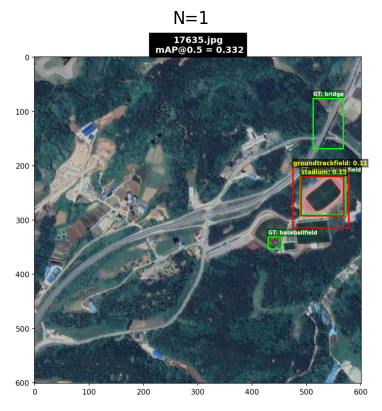

/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N3-1/figures/batch0_img0.png


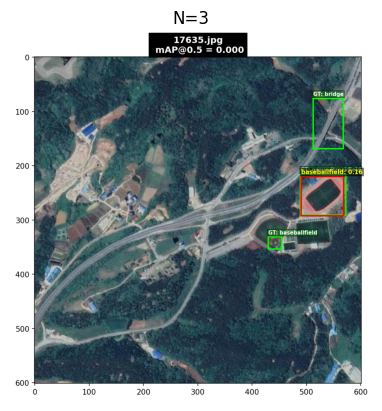

/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N5-1/figures/batch0_img0.png


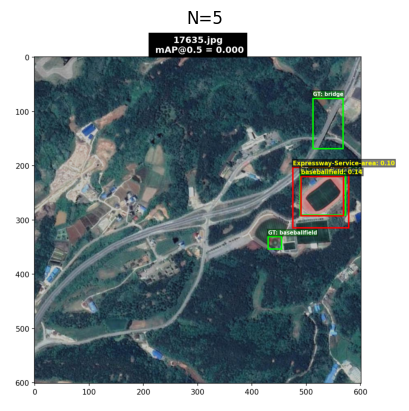

/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N10-1/figures/batch0_img0.png


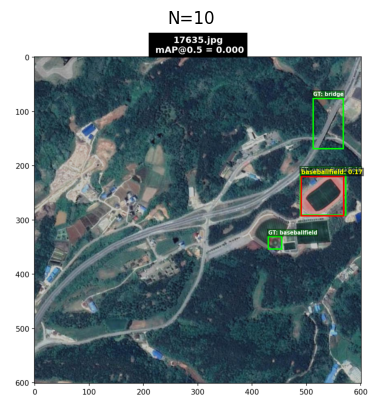

/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N30-1/figures/batch0_img0.png


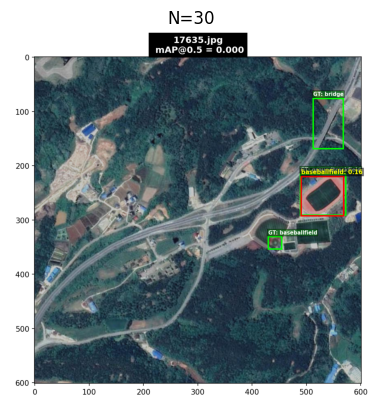

/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N100-1/figures/batch0_img0.png


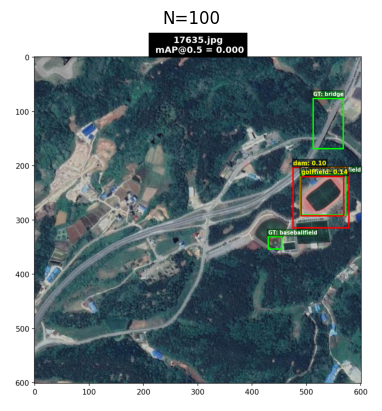

In [136]:
M = 1
img_name = 'batch0_img0.png'
#img_idx = 5

for N in [1,3,5,10,30,100]:
    img_dir = f'/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/sample/N{N}-{M}/figures'
    
    # Get all JPG files and sort them
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
    # img_path = img_paths[img_idx]
    img_path = f'{img_dir}/{img_name}'
    print(img_path)

    # # Create figure
    # fig, axes = plt.subplots(3, 3, figsize=(30,30))  # 2 rows × 5 columns grid
    # axes = axes.flatten()
    
    if os.path.exists(img_path):
        img = np.array(Image.open(img_path).convert("RGB"))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'N={N}')
        plt.show()
    
#     for i, ax in enumerate(axes):
#         if i < len(img_paths):
#             img = np.array(Image.open(img_paths[i]).convert("RGB"))

#             # Optional: clip outliers for display
#             low, high = np.percentile(img, [1, 99])
#             img = np.clip(img, low, high)
#             img = (img - img.min()) / (img.max() - img.min())

#             ax.imshow(img)
#             ax.set_title(os.path.basename(img_paths[i]), fontsize=8)
#             ax.axis("off")
#         else:
#             ax.axis("off")

    # plt.tight_layout()
    # plt.show()

In [ ]:
img_dir = '/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/N10-1-testontrain2/figures'

# Get all JPG files and sort them
img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))

#img_paths = img_paths[:9]
img_paths = random.sample(img_paths, 9)

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(30,30))  # 2 rows × 5 columns grid
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(img_paths):
        img = np.array(Image.open(img_paths[i]).convert("RGB"))
        
        # Optional: clip outliers for display
        low, high = np.percentile(img, [1, 99])
        img = np.clip(img, low, high)
        img = (img - img.min()) / (img.max() - img.min())
        
        ax.imshow(img)
        ax.set_title(os.path.basename(img_paths[i]), fontsize=8)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
img_dir = '/home/gridsan/manderson/ovdsat/run/eval/detection/dior/coop_prototypes/backbone_remoteclip-14_boxes/N30-1-testontrain2/figures'

# Get all JPG files and sort them
img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))

#img_paths = img_paths[:9]
img_paths = random.sample(img_paths, 9)

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(30,30))  # 2 rows × 5 columns grid
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(img_paths):
        img = np.array(Image.open(img_paths[i]).convert("RGB"))
        
        # Optional: clip outliers for display
        low, high = np.percentile(img, [1, 99])
        img = np.clip(img, low, high)
        img = (img - img.min()) / (img.max() - img.min())
        
        ax.imshow(img)
        ax.set_title(os.path.basename(img_paths[i]), fontsize=8)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

### Plots trends

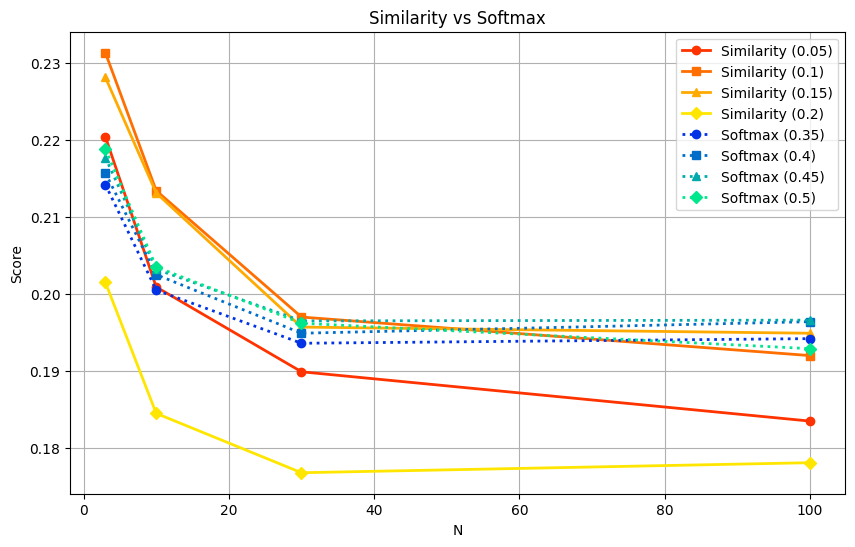

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis
samples = [3, 10, 30, 100]

# Data
similarity = {
    0.05: [0.2204, 0.2009, 0.1899, 0.1835],
    0.10: [0.2313, 0.2134, 0.1970, 0.1920],
    0.15: [0.2281, 0.2131, 0.1957, 0.1949],
    0.20: [0.2015, 0.1845, 0.1768, 0.1781],
}

softmax = {
    0.35: [0.2142, 0.2005, 0.1936, 0.1942],
    0.40: [0.2157, 0.2025, 0.1949, 0.1964],
    0.45: [0.2177, 0.2032, 0.1965, 0.1966],
    0.50: [0.2188, 0.2035, 0.1962, 0.1929],
}

markers = ['o', 's', '^', 'D']

# Create rainbow-ordered color ramps
sim_colors = plt.cm.autumn(np.linspace(0.2, 0.9, len(similarity)))   # warm rainbow
soft_colors = plt.cm.winter(np.linspace(0.2, 0.9, len(softmax)))     # cool rainbow

plt.figure(figsize=(10, 6))

# Similarity: warm rainbow, solid
for (conf, values), color, marker in zip(similarity.items(), sim_colors, markers):
    plt.plot(
        samples,
        values,
        color=color,
        linestyle='-',
        marker=marker,
        linewidth=2,
        label=f"Similarity ({conf})"
    )

# Softmax: cool rainbow, dotted
for (conf, values), color, marker in zip(softmax.items(), soft_colors, markers):
    plt.plot(
        samples,
        values,
        color=color,
        linestyle=':',
        marker=marker,
        linewidth=2,
        label=f"Softmax ({conf})"
    )

plt.xlabel("N")
plt.ylabel("Score")
plt.title("Similarity vs Softmax")
plt.legend()
plt.grid(True)

plt.show()

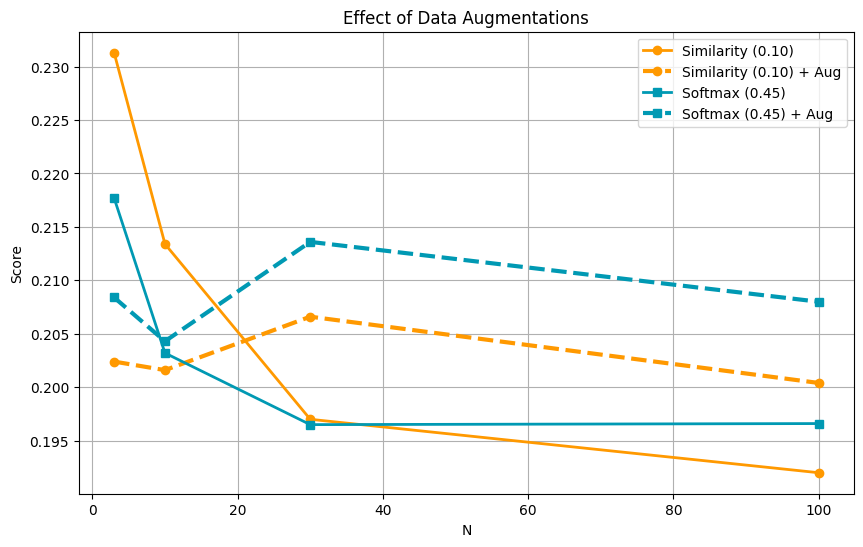

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis
samples = [3, 10, 30, 100]

# Data
sim_010 = [0.2313, 0.2134, 0.1970, 0.1920]
sim_010_aug = [0.2024, 0.2016, 0.2066, 0.2004]

soft_045 = [0.2177, 0.2032, 0.1965, 0.1966]
soft_045_aug = [0.2084, 0.2043, 0.2136, 0.2080]

# Colors (same warm / cool scheme)
sim_color = plt.cm.autumn(0.6)
soft_color = plt.cm.winter(0.6)

plt.figure(figsize=(10, 6))

# Similarity
plt.plot(
    samples,
    sim_010,
    color=sim_color,
    linestyle='-',
    marker='o',
    linewidth=2,
    label="Similarity (0.10)"
)

plt.plot(
    samples,
    sim_010_aug,
    color=sim_color,
    linestyle='--',
    marker='o',
    linewidth=3,
    label="Similarity (0.10) + Aug"
)

# Softmax
plt.plot(
    samples,
    soft_045,
    color=soft_color,
    linestyle='-',
    marker='s',
    linewidth=2,
    label="Softmax (0.45)"
)

plt.plot(
    samples,
    soft_045_aug,
    color=soft_color,
    linestyle='--',
    marker='s',
    linewidth=3,
    label="Softmax (0.45) + Aug"
)

plt.xlabel("N")
plt.ylabel("Score")
plt.title("Effect of Data Augmentations")
plt.legend()
plt.grid(True)

plt.show()



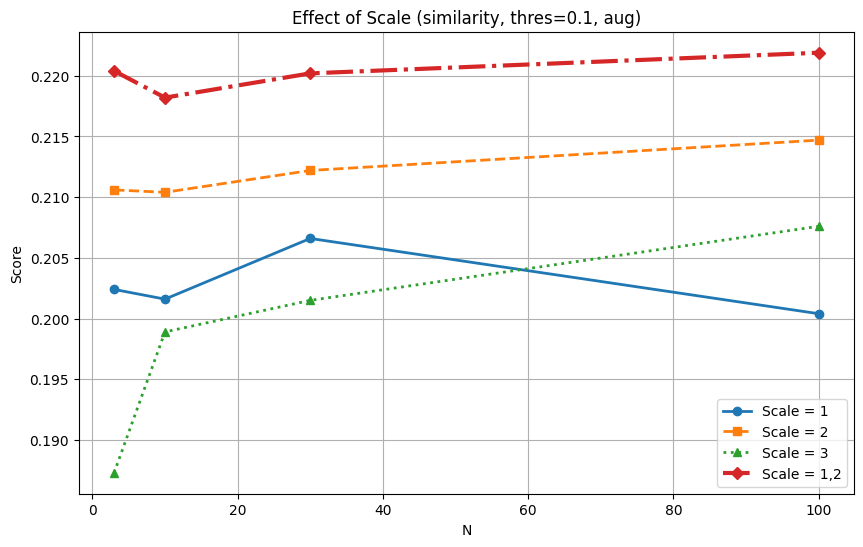

In [7]:
import matplotlib.pyplot as plt

# X-axis
samples = [3, 10, 30, 100]

# CoOp test (7, augmentations) — similarity
scale_1  = [0.2024, 0.2016, 0.2066, 0.2004]
scale_2  = [0.2106, 0.2104, 0.2122, 0.2147]
scale_3  = [0.1873, 0.1989, 0.2015, 0.2076]
scale_12 = [0.2204, 0.2182, 0.2202, 0.2219]

plt.figure(figsize=(10, 6))

plt.plot(
    samples, scale_1,
    marker='o', linestyle='-',
    linewidth=2, label="Scale = 1"
)

plt.plot(
    samples, scale_2,
    marker='s', linestyle='--',
    linewidth=2, label="Scale = 2"
)

plt.plot(
    samples, scale_3,
    marker='^', linestyle=':',
    linewidth=2, label="Scale = 3"
)

plt.plot(
    samples, scale_12,
    marker='D', linestyle='-.',
    linewidth=3, label="Scale = 1,2"
)

plt.xlabel("N")
plt.ylabel("Score")
plt.title("Effect of Scale (similarity, thres=0.1, aug)")
plt.legend()
plt.grid(True)

plt.show()


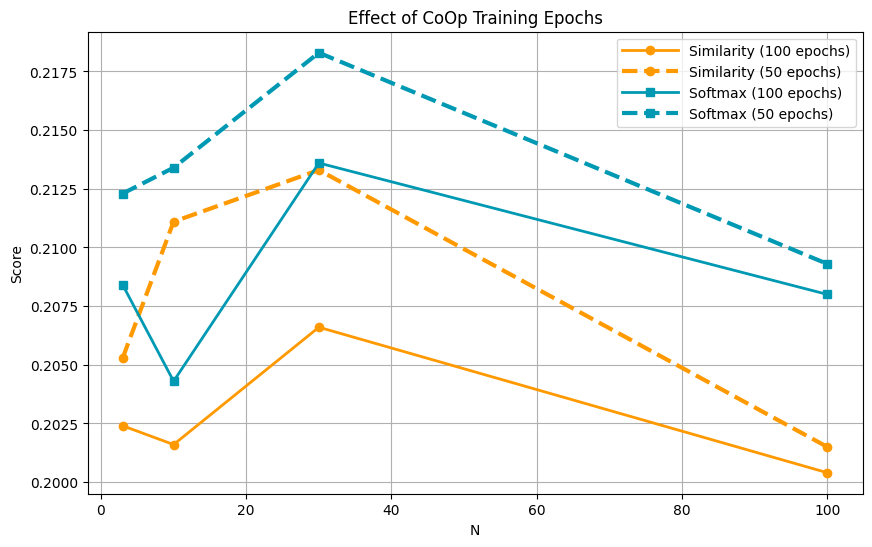

In [11]:
import matplotlib.pyplot as plt

# X-axis
samples = [3, 10, 30, 100]

# CoOp test 7 (augmentations)
sim_t7 = [0.2024, 0.2016, 0.2066, 0.2004]
soft_t7 = [0.2084, 0.2043, 0.2136, 0.2080]

# CoOp test 8 (augmentations, epochs=50)
sim_t8 = [0.2053, 0.2111, 0.2133, 0.2015]
soft_t8 = [0.2123, 0.2134, 0.2183, 0.2093]

# Match previous colors
sim_color = plt.cm.autumn(0.6)   # orange
soft_color = plt.cm.winter(0.6)  # blue

plt.figure(figsize=(10, 6))

# Similarity (0.1)
plt.plot(
    samples, sim_t7,
    color=sim_color, linestyle='-', marker='o',
    linewidth=2, label="Similarity (100 epochs)"
)

plt.plot(
    samples, sim_t8,
    color=sim_color, linestyle='--', marker='o',
    linewidth=3, label="Similarity (50 epochs)"
)

# Softmax (0.45)
plt.plot(
    samples, soft_t7,
    color=soft_color, linestyle='-', marker='s',
    linewidth=2, label="Softmax (100 epochs)"
)

plt.plot(
    samples, soft_t8,
    color=soft_color, linestyle='--', marker='s',
    linewidth=3, label="Softmax (50 epochs)"
)

plt.xlabel("N")
plt.ylabel("Score")
plt.title("Effect of CoOp Training Epochs")
plt.legend()
plt.grid(True)

plt.legend(handlelength=4)
plt.show()